# Parsing

In [45]:
import math

def lmap(f,x):
    return list(map(f,x))

def loadCSV(path, x_id=0, y_id=1):
    with open(path) as inp:
        lines = inp.read().split("\n")[1:-2]
        rows = lmap(lambda l: lmap(float, l.strip().split(",")), lines)

        return {"x": lmap(lambda r: r[x_id], rows), "y": lmap(lambda r: r[y_id], rows)}

def process_raw_decay_data(id, startTime = -1, threshold = 0.7, col_id=2, SR=250, salt = "", floating_avg = True):
    peaks = []

    # startTime == -1 => auto cutoff
    auto_cutoff = False
    if(startTime == -1):
        auto_cutoff = True
        startTime = 0

    with open(f"./inputs/{id}.csv") as inp:
        lines = inp.read().split("\n")

        startInd = 1
        while (float(lines[startInd].split(",")[0]) < startTime): startInd += 1
        
        hitPeak = False
        startPeak = 0
        endPeak = 0
        for i in range(startInd, len(lines)-1):
            row = lines[i].split(",")

            # convert to true time

            if (float(row[col_id]) >= threshold and not hitPeak):
                hitPeak = True
                startPeak = float(row[0])/SR


            if (float(row[col_id]) < threshold and hitPeak):
                hitPeak = False
                endPeak = float(row[0])/SR

                peaks.append((endPeak+startPeak)/2)                

    

    results = {}
    interval = 1.5
    step = 0.1
    curTime = startTime
    x = 0
    while x < len(peaks):
        if (peaks[x] > curTime+interval):
            curTime += step
            x = 0
        elif (peaks[x] > curTime and peaks[x] < curTime+interval):
            if (not curTime in results): results[curTime] = 1
            else: results[curTime] += 1
            
        x += 1

    cutoff_val = math.inf
    if(auto_cutoff):
        cutoff_val = 0

    if(floating_avg):   
        with open(f"./outputs/{id}_{salt}_PROCESSED_FLOATING_AVERAGE.csv", 'w') as res:
            res.write("t, peaks/s, omega \n")
            for x in range(4, len(results.keys())):
                flAverage = 0
                for y in range(5):
                    flAverage += results[list(results.keys())[x-y]]
                flAverage = flAverage/5
                flAverage /= interval

                if(auto_cutoff):
                    if(flAverage > cutoff_val):
                        cutoff_val = flAverage

                if(flAverage < cutoff_val):
                    res.write(str(round(list(results.keys())[x-y], 1)) + "," + str(flAverage) + "," + str(flAverage*2*2*math.pi/16) + "\n")

        return f"./outputs/{id}_{salt}_PROCESSED_FLOATING_AVERAGE.csv"
    else:
        with open(f"./outputs/{id}_{salt}_PROCESSED.csv", 'w') as res:
            res.write("t, peaks/s \n")
            for key in results.keys():
                res.write(str(round(key, 1)) + "," + str(results[key]) + "\n")
        
        return f"./outputs/{id}_{salt}_PROCESSED.csv"


In [46]:
import math
import matplotlib.pyplot as plt
import matplotlib.lines as mpl_lines
import numpy as np

%matplotlib widget

SR0 = 250
SRs = [
    250,
    250,
    250,
    # 250,
    500,
    1250*2,
]
paths = [
    "1_to_1",
    "2_to_1whole",
    "1_to_2",
    # "1_to_2+",
    "3_to_1",
    "1_to_1_highRPM_trim",
]

notes = [
    "",
    " (drops into a lower mode)",
    "",
    # "+",
    "",
    " at high RPM"
]

target_ratio = [
    1,
    2,
    1/2,
    # 1/2
    3,
    1

]

cols = [
    "tab:blue",
    "tab:green",
    "tab:red",
    "tab:purple",
    "tab:cyan",
    # "tab:orange",
]

processed_paths = []
for i in range(len(paths)):
    p = paths[i]
    processed_paths.append(
        process_raw_decay_data(p, 0, -45, col_id=1, salt="CH1", SR=SR0)
    )
    processed_paths.append(
        process_raw_decay_data(p, 0, -750, col_id=2, salt="CH2", SR=SR0)
    )

# View


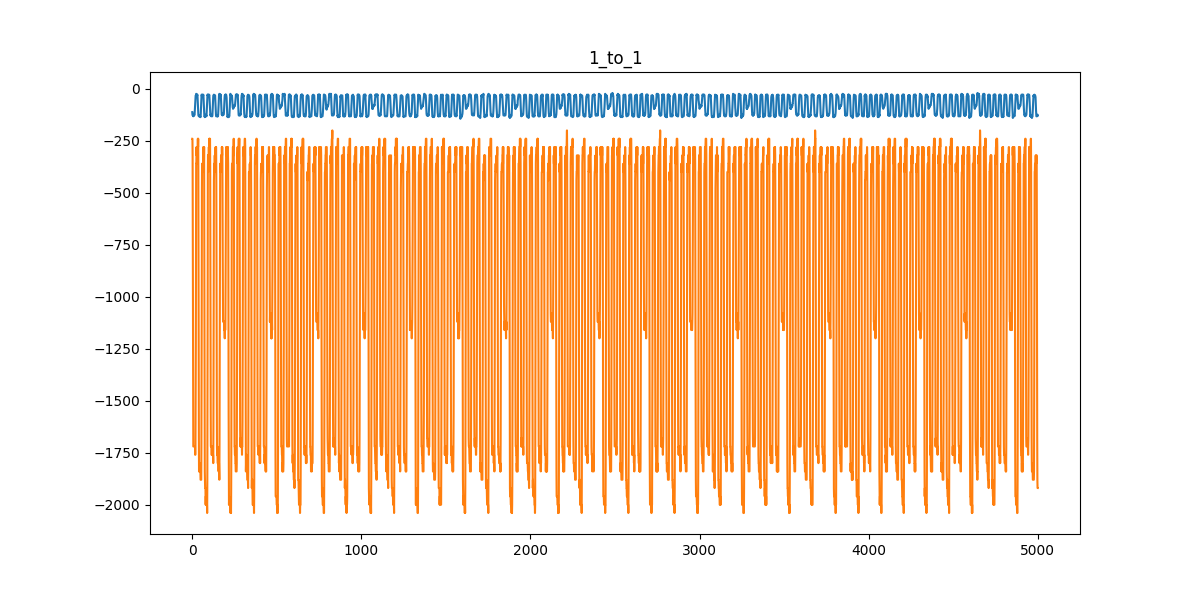

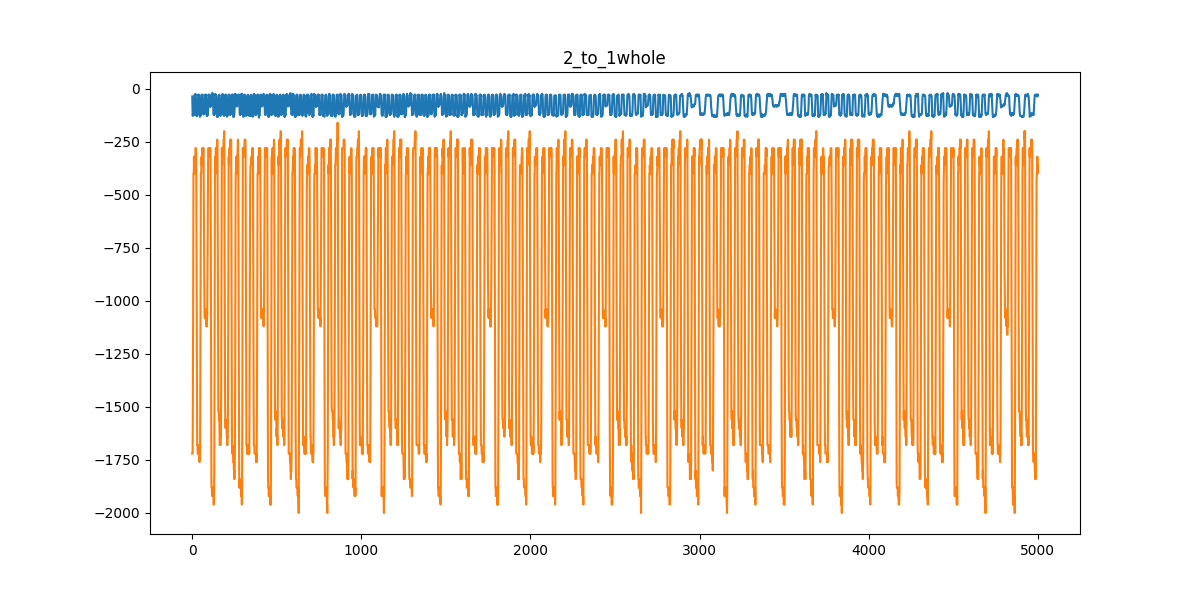

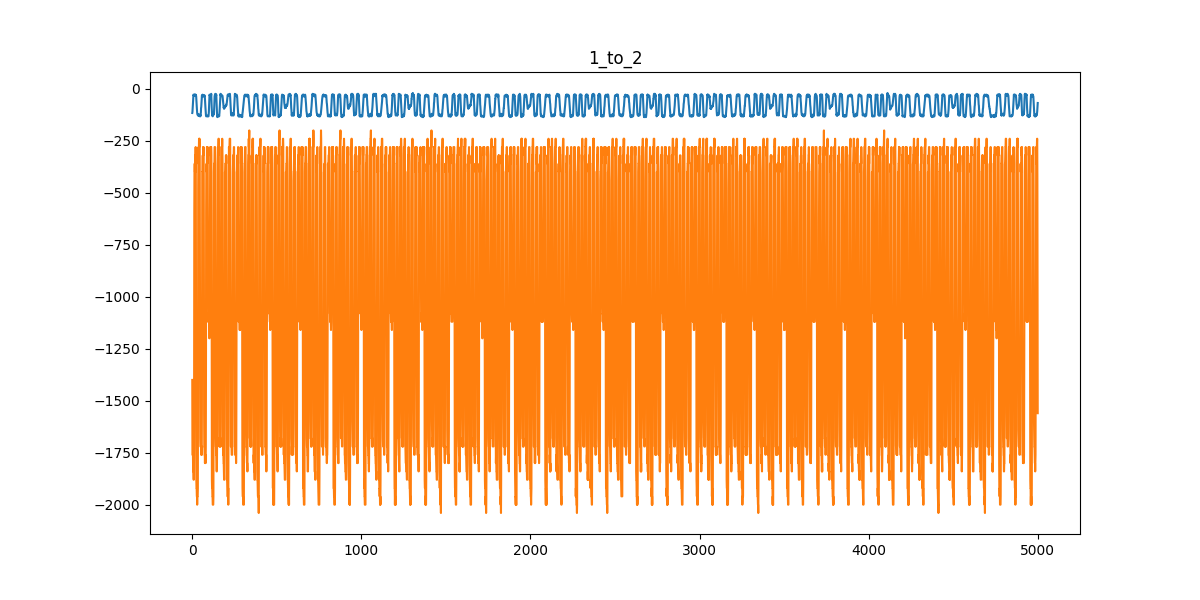

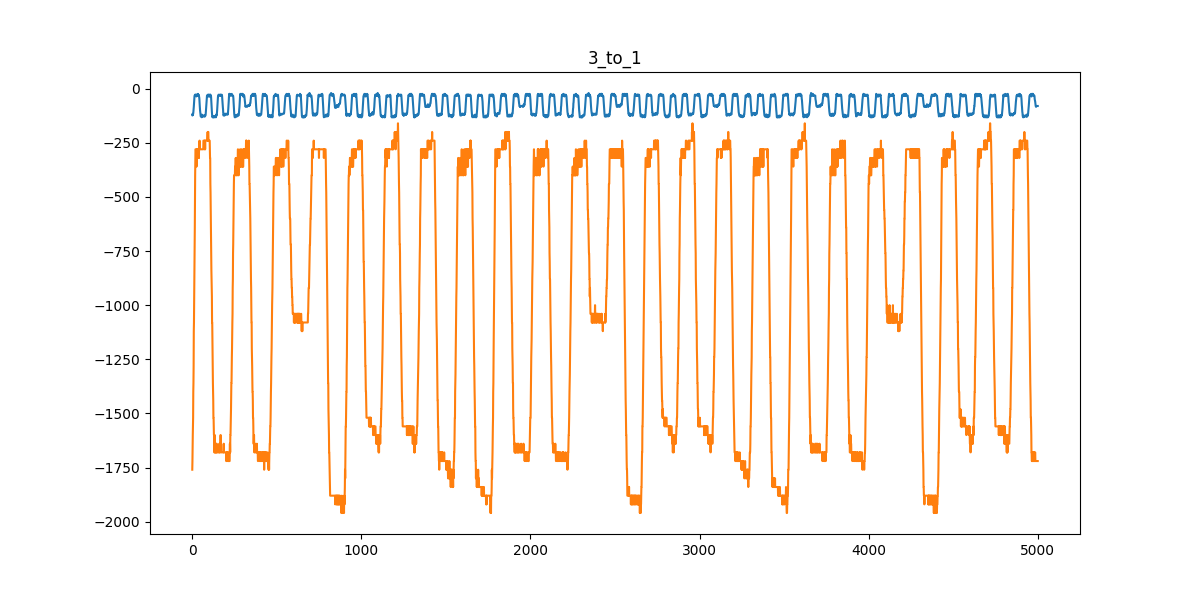

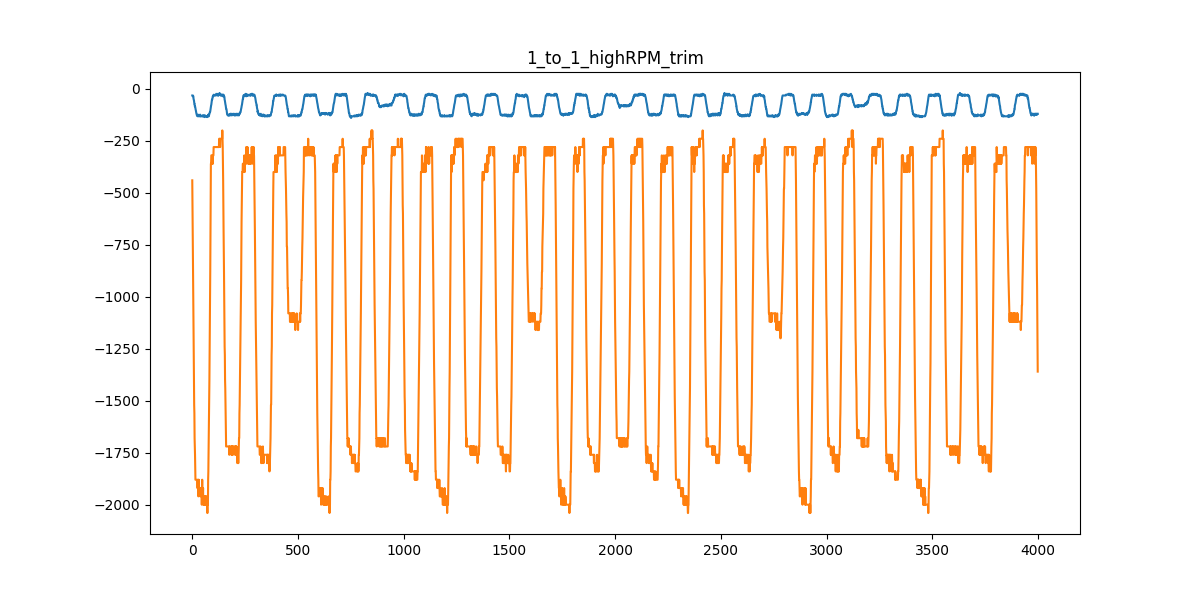

In [47]:
for p in paths:
    plt.figure(figsize=[12, 6])
    
    CH1 = loadCSV("inputs/" + p + ".csv", 0, 1)
    CH2 = loadCSV("inputs/" + p + ".csv", 0, 2)

    plt.title(p)
    plt.plot(
        CH1["x"], 
        CH1["y"], 
        label="CH1",
    )
    
    plt.plot(
        CH2["x"], 
        CH2["y"], 
        label="CH2",
    )

# Processing

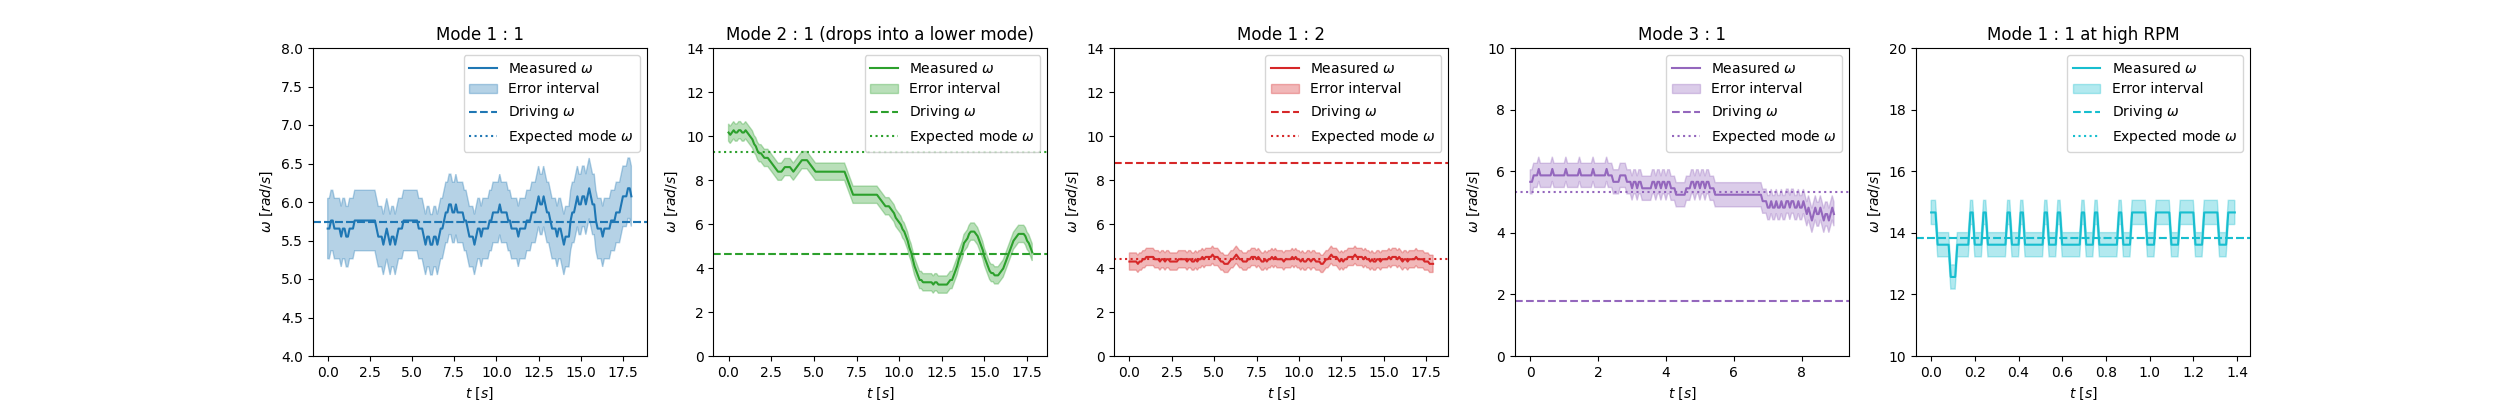

In [48]:
fig, ax = plt.subplots(1, 5, figsize=[5 * 5, 4])

ylims = [
    [4, 8],
    [0, 14],
    [0, 14],
    [0, 10],
    [10, 20]
]

for j in range(int(len(processed_paths)/2)):
    path_CH1 = processed_paths[2*j]
    path_CH2 = processed_paths[2*j + 1]
    
    CH1 = loadCSV(path_CH1, 0, 2)
    CH2 = loadCSV(path_CH2, 0, 2)

    # ax_x = math.floor(j/2)
    # ax_y = j%2

    ax[j].plot(
        np.array(CH1["x"]) * SR0/SRs[j], 
        np.array(CH1["y"]) * SRs[j]/SR0, 
        c = cols[j],
        linestyle="-",
        label="Measured $\\omega$"
    )
    ax[j].fill(
        np.array(CH1["x"] + CH1["x"][::-1]) * SR0/SRs[j],
        np.array(
            list(np.array(CH1["y"]) + math.pi/8 * SR0/SRs[j]) + 
            list(np.array(CH1["y"][::-1]) - math.pi/8 * SR0/SRs[j])
        ) * SRs[j]/SR0,
        c = cols[j],
        alpha=0.33,
        label="Error interval"
    )

    # ax[j].plot(
    #     np.array(CH2["x"]) * SR0/SRs[j], 
    #     np.array(CH2["y"]) * target_ratio[j] * SRs[j]/SR0, 
    #     label=path_CH2,
    #     c = cols[j],
    #     linestyle=":"
    # )

    ax[j].axhline(
        np.average(CH2["y"]) * SRs[j]/SR0,
        xmin = CH2["x"][0] * SR0/SRs[j],
        xmax = CH2["x"][-1] * SR0/SRs[j],
        label="Driving $\\omega$",
        c = cols[j],
        linestyle="--"
    )

    ax[j].axhline(
        np.average(CH2["y"]) * target_ratio[j] * SRs[j]/SR0,
        xmin = CH2["x"][0] * SR0/SRs[j],
        xmax = CH2["x"][-1] * SR0/SRs[j],
        label="Expected mode $\\omega$",
        c = cols[j],
        linestyle=":"
    )

    # ax[j].set_ylim(0, 14)
    ax[j].set_ylim(ylims[j][0], ylims[j][1])
    ax[j].set_xlabel("$t$ $[s]$")
    ax[j].set_ylabel("$\\omega$ $[rad/s]$")
    ax[j].legend()
    ax[j].set_title(f"Mode {paths[j][0]} : {paths[j][5]}{notes[j]}")

# ax[0,0].title("Transfer modes")
plt.savefig("magnetic_modes.png", format="png", dpi=500)
